# Imports

In [1]:
!pip install python-bidi


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
from google.colab import drive
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import os
import shutil
import seaborn as sns
import math


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# relevant_cols = ['speaker_name', 'sentence_text', 'knesset_number', 'session_name', 'protocol_date','speaker_gender', 'speaker_religion','speaker_residence', 'faction_general_name']
# folder_path = '/content/drive/MyDrive/data_mining_knesset_final/speeches'
# files = os.listdir(folder_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#parsing data into a df



In [4]:
# unite tagged files into one df
drive.mount('/content/drive/', force_remount=True)
folder_path = "/content/drive/MyDrive/data_mining_knesset_final/tagged_99_22"
files = os.listdir(folder_path)
print(files)
main_df = pd.DataFrame()
for i in range(0,len(files)):
  filename = files[i]
  full_path = os.path.join(folder_path, filename)
  df_cur = pd.read_csv(full_path, encoding = "utf-8")
  # add the current df to the entire df
  main_df = pd.concat([main_df, df_cur], axis=0)

main_df.reset_index(drop=True, inplace=True)
print(main_df.columns)



Mounted at /content/drive/
['main_df_ttaged_part_1.csv', 'main_df_ttaged_part_2.csv', 'main_df_ttaged_part_3.csv', 'main_df_ttaged_part_4.csv']


<ipython-input-4-373d862f9493>:10: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cur = pd.read_csv(full_path, encoding = "utf-8")


Index(['speaker_name', 'sentence_text', 'knesset_number', 'session_name',
       'protocol_date', 'morphological_fields', 'speaker_gender',
       'speaker_religion', 'speaker_residence', 'faction_general_name',
       'faction_political_orientation', 'predicted_label'],
      dtype='object')


# Clean and process the Data Frame

In [5]:
#fill nan cells under faction_general_name column
main_df['faction_general_name'].fillna('אורח', inplace=True)


#Tests for data processing

In [6]:
main_df['protocol_date'] = pd.to_datetime(main_df['protocol_date'])
# find the oldest date and newest date
oldest_date = main_df['protocol_date'].min()
newest_date = main_df['protocol_date'].max()
print("newest date:", newest_date, "oldest date: ", oldest_date)

#check if nan in faction
print(main_df['faction_general_name'].isna().sum())

print(main_df.columns)

newest date: 2022-09-14 13:00:00 oldest date:  1999-07-19 10:00:00
0
Index(['speaker_name', 'sentence_text', 'knesset_number', 'session_name',
       'protocol_date', 'morphological_fields', 'speaker_gender',
       'speaker_religion', 'speaker_residence', 'faction_general_name',
       'faction_political_orientation', 'predicted_label'],
      dtype='object')


# Statistics gathering from our non - labeled data

In [7]:
# init the first df
folder_path = '/content/drive/MyDrive/data_mining_knesset_final/unlabeled_99to22'
files = os.listdir(folder_path)
files = [f for f in files if "main_df_unttaged_part" in f]

unlabeled_data = pd.read_csv(os.path.join(folder_path, files[0]), encoding = "utf-8")

for i in range(1,len(files)):
  filename = files[i]
  full_path = os.path.join(folder_path, filename)
  df_cur = pd.read_csv(full_path, encoding = "utf-8")
  # add the current df to the entire df
  unlabeled_data = pd.concat([unlabeled_data, df_cur], axis=0)
unlabeled_data.reset_index(drop=True, inplace=True)


<ipython-input-7-06481d696685>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cur = pd.read_csv(full_path, encoding = "utf-8")


In [8]:
unlabeled_data.shape

(1166075, 11)

In [9]:
unlabeled_data

,speaker_name,sentence_text,knesset_number,session_name,protocol_date,morphological_fields,speaker_gender,speaker_religion,speaker_residence,faction_general_name,faction_political_orientation
0,אורית אדטו,"שוב, זה רק בגלל שיש כמה מתקנים חדשים.אם מורידי...",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00,"{'id': ['1', '2', '3', '4', '5', '6---7', '6',...",NaN,NaN,NaN,NaN,NaN
1,אופיר פינס-פז,"אני מודיע לך, שבבתי המעצר של המשטרה, אני לא מא...",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00,"{'id': ['1', '2', '3---4', '3', '4', '5', '6--...",male,יהודי,רעננה,העבודה,שמאל
2,מרדכי ורטהיימר,"נכון, אם אנחנו מצרפים חייבי שב""ס והמשטרה, אנחנ...",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00,"{'id': ['1', '2', '3', '4', '5', '6', '7', '8-...",NaN,NaN,NaN,NaN,NaN
3,אופיר פינס-פז,"תודה רבה.אגף התקציבים, אומרים פה כולם שחסרים א...",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00,"{'id': ['1', '2', '3'], 'form': ['תודה', 'רבה'...",male,יהודי,רעננה,העבודה,שמאל
4,עמית שפייזמן,"עד כמה שידוע לי מהנתונים שיש אצלי, יש כיום תקן...",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00,"{'id': ['1', '2', '3---4', '3', '4', '5---6', ...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1166070,<ענת הר אבן,"""תקנות המסים (גביה) (תשלום לצד שלישי שהומצא לו...",20,"ועדת החוקה, חוק ומשפט",2017-05-16 09:00,NaN,NaN,NaN,NaN,NaN,NaN
1166071,אלעזר שטרן,"אני רוצה לשאול לגבי התנאי של 2,500 צווי עיקול....",20,"ועדת החוקה, חוק ומשפט",2017-05-16 09:00,NaN,male,יהודי,מצפה הושעיה,יש עתיד,מרכז
1166072,<ענת הר אבן,"לא, אין פה הבדל בין ההוצאה לפועל למרכז לגביית ...",20,"ועדת החוקה, חוק ומשפט",2017-05-16 09:00,NaN,NaN,NaN,NaN,NaN,NaN
1166073,אלעזר שטרן,"בסדר גמור, אבל למה התנאי של 2,500 צווים?",20,"ועדת החוקה, חוק ומשפט",2017-05-16 09:00,NaN,male,יהודי,מצפה הושעיה,יש עתיד,מרכז


## Number of words along the years

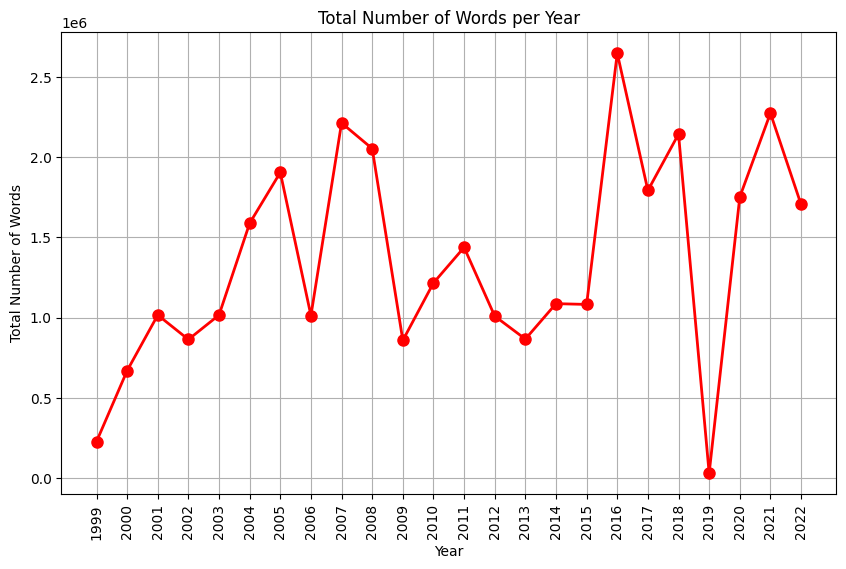

In [10]:
# Create a graph of number of words along the years
unlabeled_data["num_of_words"] = unlabeled_data["sentence_text"].apply(lambda x: len(x.split()))
unlabeled_data["year"] = pd.to_datetime(unlabeled_data["protocol_date"]).dt.year
years = np.unique(unlabeled_data["year"])
years.sort()

# create a plot
unlabeled_df_num_words = unlabeled_data.groupby('year')['num_of_words'].agg('sum')
plt.figure(figsize=(10, 6))
plt.plot(unlabeled_df_num_words.index, unlabeled_df_num_words.values, marker='o', linestyle='-', color='r', linewidth=2, markersize=8)
plt.xlabel('Year')
plt.ylabel('Total Number of Words')
plt.xticks(years, rotation=90)
plt.title('Total Number of Words per Year')
plt.grid(True)
plt.show()



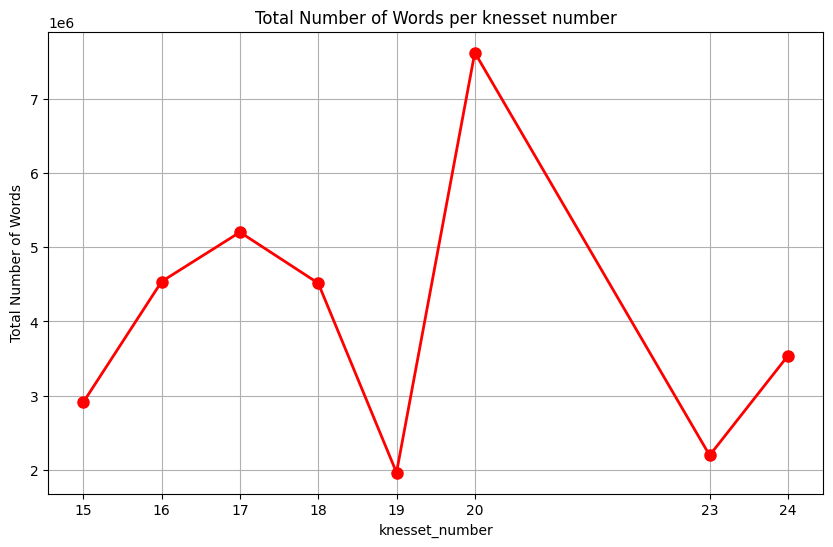

In [11]:
# Create a graph of number of words per knesset number
knesset_numbers = np.unique(unlabeled_data["knesset_number"])
knesset_numbers.sort()

# create a plot
unlabeled_df_num_words = unlabeled_data.groupby('knesset_number')['num_of_words'].agg('sum')
plt.figure(figsize=(10, 6))
plt.plot(unlabeled_df_num_words.index, unlabeled_df_num_words.values, marker='o', linestyle='-', color='r', linewidth=2, markersize=8)
plt.xlabel('knesset_number')
plt.ylabel('Total Number of Words')
plt.xticks(knesset_numbers)
plt.title('Total Number of Words per knesset number')
plt.grid(True)
plt.show()

## Solidarity Score

solidatiry score = mean (words per meeting) * std(number of meetings)

In [12]:
meetings_per_knesset = unlabeled_data.groupby('knesset_number')['protocol_date'].nunique()
meetings_per_knesset

,protocol_date
knesset_number,
15,520
16,640
17,666
18,677
19,282
20,683
23,205
24,321


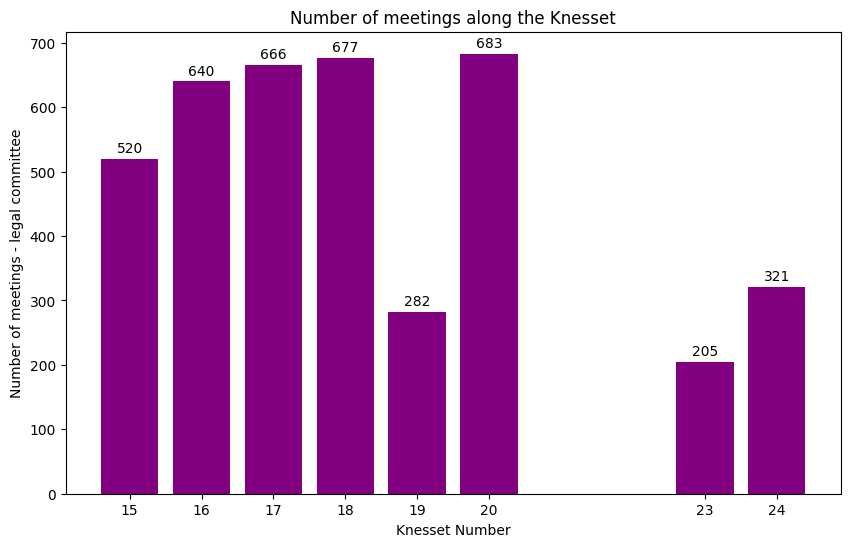

In [13]:
# plot the number of meetings for each knesset
plt.figure(figsize=(10, 6))
bars = plt.bar(meetings_per_knesset.index, meetings_per_knesset.values, color='purple')
plt.xlabel('Knesset Number')
plt.ylabel('Number of meetings - legal committee')
plt.title('Number of meetings along the Knesset')
plt.xticks(meetings_per_knesset.index)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 5, int(h), ha='center', va='bottom')


plt.show()


In [14]:
# get standard deriviation of the number of meetings per knesset and avg words per meeting
std_meetings = meetings_per_knesset.std()
avg_words_meeting = unlabeled_data.groupby('protocol_date')['num_of_words'].mean()


In [15]:
unlabeled_df_avg = unlabeled_data.merge(avg_words_meeting.rename('avg_words_per_meeting'), on='protocol_date')
unlabeled_df_avg['soladirity_score'] = unlabeled_df_avg['avg_words_per_meeting'] * std_meetings
unlabeled_df_avg

,speaker_name,sentence_text,knesset_number,session_name,protocol_date,morphological_fields,speaker_gender,speaker_religion,speaker_residence,faction_general_name,faction_political_orientation,num_of_words,year,avg_words_per_meeting,soladirity_score
0,אורית אדטו,"שוב, זה רק בגלל שיש כמה מתקנים חדשים.אם מורידי...",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00,"{'id': ['1', '2', '3', '4', '5', '6---7', '6',...",NaN,NaN,NaN,NaN,NaN,13,2002,43.678082,8719.370244
1,אופיר פינס-פז,"אני מודיע לך, שבבתי המעצר של המשטרה, אני לא מא...",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00,"{'id': ['1', '2', '3---4', '3', '4', '5', '6--...",male,יהודי,רעננה,העבודה,שמאל,14,2002,43.678082,8719.370244
2,מרדכי ורטהיימר,"נכון, אם אנחנו מצרפים חייבי שב""ס והמשטרה, אנחנ...",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00,"{'id': ['1', '2', '3', '4', '5', '6', '7', '8-...",NaN,NaN,NaN,NaN,NaN,207,2002,43.678082,8719.370244
3,אופיר פינס-פז,"תודה רבה.אגף התקציבים, אומרים פה כולם שחסרים א...",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00,"{'id': ['1', '2', '3'], 'form': ['תודה', 'רבה'...",male,יהודי,רעננה,העבודה,שמאל,9,2002,43.678082,8719.370244
4,עמית שפייזמן,"עד כמה שידוע לי מהנתונים שיש אצלי, יש כיום תקן...",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00,"{'id': ['1', '2', '3---4', '3', '4', '5---6', ...",NaN,NaN,NaN,NaN,NaN,17,2002,43.678082,8719.370244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166070,<שלום לרנר,"זאת אומרת, אני קונה בית ב-2.2 מיליון, אני לוקח...",20,"ועדת החוקה, חוק ומשפט",2017-05-16 10:30,NaN,NaN,NaN,NaN,NaN,NaN,21,2017,24.778210,4946.425693
1166071,אוסאמה סעדי,"טוב רבותי, תם ולא נשלם.",20,"ועדת החוקה, חוק ומשפט",2017-05-16 10:30,NaN,male,מוסלמי,NaN,הרשימה המשותפת,ערבים,5,2017,24.778210,4946.425693
1166072,אוסאמה סעדי,"שלום, לסיכום אני מבקש ממשרד המשפטים באמת לעשות...",20,"ועדת החוקה, חוק ומשפט",2017-05-16 10:30,NaN,male,מוסלמי,NaN,הרשימה המשותפת,ערבים,39,2017,24.778210,4946.425693
1166073,<בקי קשת,אפשר גם לבקש נתונים?,20,"ועדת החוקה, חוק ומשפט",2017-05-16 10:30,NaN,NaN,NaN,NaN,NaN,NaN,4,2017,24.778210,4946.425693


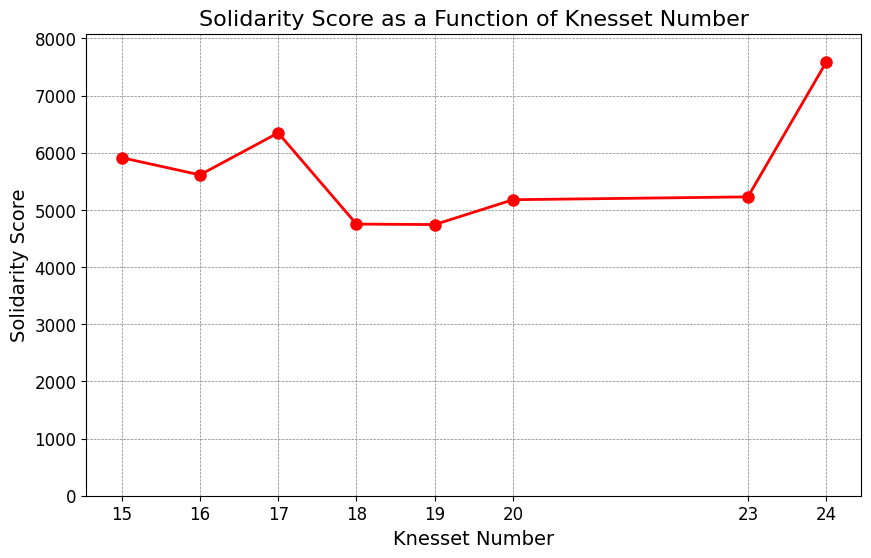

In [16]:
# plot solidarity score
average_score_per_knesset = unlabeled_df_avg.groupby('knesset_number')['soladirity_score'].mean()

# plot soladirity score as a function of the knesset number
plt.figure(figsize=(10, 6))
plt.plot(average_score_per_knesset.index, average_score_per_knesset.values, marker='o', linestyle='-', color='r', linewidth=2, markersize=8)
plt.gca().set_facecolor('white')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.title('Solidarity Score as a Function of Knesset Number', fontsize=16)
plt.xlabel('Knesset Number', fontsize=14)
plt.ylabel('Solidarity Score', fontsize=14)
plt.xticks(average_score_per_knesset.index, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(average_score_per_knesset.values) + 500)
plt.show()

#statistics gathering from our labeled df

In [17]:
# create a df for each kensset period, and for each period devide the df into factions.
knesset_numbers = np.sort(main_df['knesset_number'].unique())
knesset_data_dict = {}

for knesset_number in knesset_numbers:
  df_knesset = main_df[main_df['knesset_number'] == knesset_number]
  faction_dict = {}
  factions = df_knesset['faction_general_name'].unique()
  for faction in factions:
    print(faction)
    faction_df = df_knesset[df_knesset['faction_general_name'] == faction]
    faction_dict[faction] = faction_df
  knesset_data_dict[knesset_number] = faction_dict


אורח
העבודה
מפלגה דתית לאומית
התאחדות הספרדים שומרי תורה
הליכוד
גשר (1)
ברית לאומית דמוקרטית
יהדות התורה
שינוי
חזית דמוקרטית לשלום ולשוויון (כמפלגה ערבית)
מרצ
ישראל בעלייה
האיחוד הלאומי - ישראל ביתנו
מפלגת המרכז
הרשימה הערבית המאוחדת (2)
עם אחד
האיחוד הלאומי
ישראל ביתנו
תנועה ערבית להתחדשות
הבחירה הדמוקרטית
חרות - התנועה הלאומית
מפלגה לאומית ערבית
הליכוד
אורח
העבודה
שינוי
מרצ
האיחוד הלאומי
אח"י
דגל התורה
מפלגה דתית לאומית
התאחדות הספרדים שומרי תורה
ברית לאומית דמוקרטית
אגודת ישראל
החזית הדמוקרטית לשלום ולשוויון - תנועה ערבית להתחדשות
קדימה
הסיעה החילונית
הרשימה הערבית המאוחדת (2)
ישראל ביתנו
יהדות התורה
עם אחד
מפלגת פועלי ארץ-ישראל
קדימה
הליכוד
התאחדות הספרדים שומרי תורה
אורח
העבודה
גיל - גמלאי ישראל לכנסת
מרצ
יהדות התורה
הבית היהודי
ברית לאומית דמוקרטית
הרשימה הערבית המאוחדת - התנועה הערבית להתחדשות
חזית דמוקרטית לשלום ולשוויון (כמפלגה ערבית)
ישראל ביתנו
צדק לזקן
דגל התורה
אח"י
ישראל ביתנו
אורח
העבודה
האיחוד הלאומי
הליכוד
הבית היהודי
התאחדות הספרדים שומרי תורה
יהדות התורה
הרשימה הערבי

In [18]:
female_percentage = {}

for knesset_num, knesset_dic in knesset_data_dict.items():  # run on data by the knesset number
    female_percentage[knesset_num] = {}

    for faction_name, faction_df in knesset_dic.items():  # run on data by the faction
        # Use the faction_political_orientation column instead of faction_general_name
        faction_orientation = faction_df['faction_political_orientation'].iloc[0]
        gender_counts = faction_df['speaker_gender'].value_counts()

        # Extract counts for male and female
        male_count = gender_counts.get('male', 0)
        female_count = gender_counts.get('female', 0)

        # Calculate female percentage, handling division by zero
        total_count = male_count + female_count
        if total_count > 0:
            female_percentage[knesset_num][faction_orientation] = female_count / total_count

print(female_percentage)

median_female_percentage = {}
averages_female_percentage = {}
for knesset_num, factions in female_percentage.items():
    # Filter out None values before calculating the median
    valid_percentages = [v for v in factions.values() if v is not None]
    if valid_percentages:
        median_female_percentage[knesset_num] = np.median(valid_percentages)
        averages_female_percentage[knesset_num] = np.mean(valid_percentages)
    else:
        median_female_percentage[knesset_num] = None  # or handle as you prefer
        averages_female_percentage[knesset_num] = None


{15: {nan: 0.055, 'שמאל': 0.0, 'דתיים': 0.0, 'חרדים': 0.0, 'ימין': 0.0, 'מרכז': 0.572463768115942, 'ערבים': 0.0}, 16: {'ימין': 0.0, nan: 0.2537313432835821, 'שמאל': 0.0, 'מרכז': 0.009153318077803204, 'דתיים': 0.02344689378757515, 'חרדים': 0.0, 'ערבים': 0.0}, 17: {'מרכז': 0.001430615164520744, 'ימין': 0.0, 'חרדים': 0.0, nan: 0.0, 'שמאל': 0.6847114812611541, 'דתיים': 0.0, 'ערבים': 0.0}, 18: {'ימין': 0.13819742489270387, nan: 0.022413793103448276, 'שמאל': 0.0, 'דתיים': 0.0, 'חרדים': 0.0, 'ערבים': 0.23622047244094488, 'מרכז': 0.23134927001443928}, 19: {'ימין': 0.00794912559618442, 'מרכז': 0.7407894736842106, nan: 0.005571030640668524, 'שמאל': 0.9909274193548387, 'דתיים': 0.8414657300170876, 'ערבים': 0.0, 'חרדים': 0.0}, 20: {nan: 1.0, 'דתיים': 0.0152608144076018, 'מרכז': 1.0, 'ערבים': 0.026529193697868398, 'חרדים': 0.0, 'שמאל': 0.0, 'ימין': 0.42441860465116277}, 23: {nan: 0.40458015267175573, 'חרדים': 0.0, 'מרכז': 0.3359242166626184, 'ערבים': 0.375, 'ימין': 0.7657657657657657, 'שמאל': 0.117

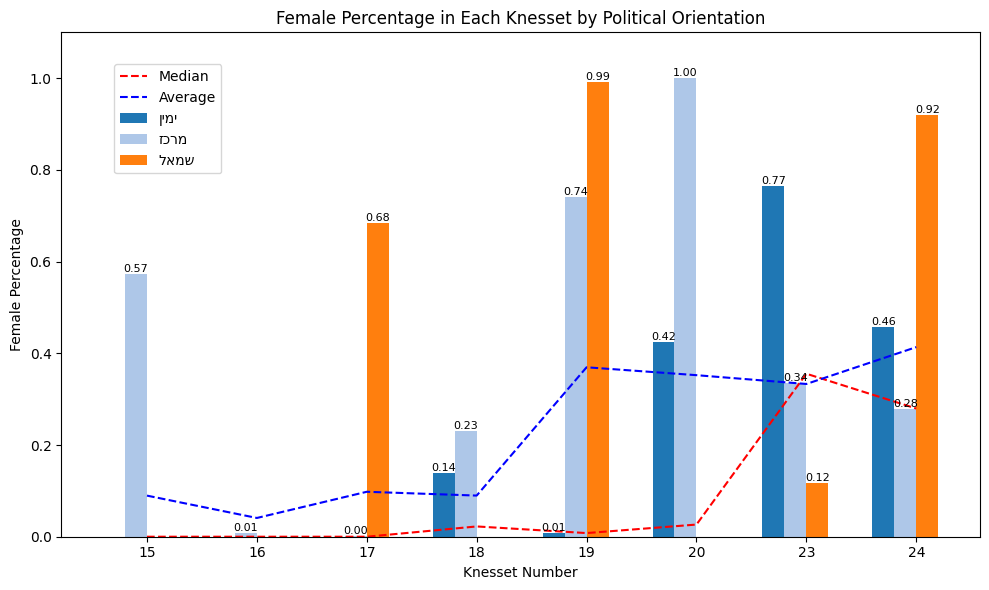

In [19]:
knesset_numbers = list(female_percentage.keys())
medians = [median_female_percentage[knesset_num] for knesset_num in knesset_numbers]
averages = [averages_female_percentage[knesset_num] for knesset_num in knesset_numbers]

political_orientations = {"ימין", "שמאל", "מרכז"}

# Generate a color map
cmap = plt.get_cmap('tab20')
orientation_colors = {orientation: cmap(i % cmap.N) for i, orientation in enumerate(sorted(political_orientations))}

plt.figure(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(knesset_numbers))
for i, orientation in enumerate(sorted(political_orientations)):
    orientation_percentages = [female_percentage[knesset_num].get(orientation, 0) for knesset_num in knesset_numbers]
    bars = plt.bar(index + i * bar_width, orientation_percentages, bar_width, color=orientation_colors[orientation], label=orientation)
    # text
    for bar in bars:
        h = bar.get_height()
        if h > 0:
            plt.text(bar.get_x() + bar.get_width() / 2, h, f'{h:.2f}', ha='center', va='bottom', fontsize=8)

# median and avg
plt.plot(index + (len(political_orientations) * bar_width) / 2, medians, color='red', linestyle='--', label='Median')
plt.plot(index + (len(political_orientations) * bar_width) / 2, averages, color='blue', linestyle='--', label='Average')
plt.xlabel('Knesset Number')
plt.ylabel('Female Percentage')
plt.xticks(index + bar_width * len(political_orientations) / 2, knesset_numbers)
plt.ylim(0, 1.1)
plt.title('Female Percentage in Each Knesset by Political Orientation')

handles, labels = plt.gca().get_legend_handles_labels()
labels = [get_display(label) for label in labels]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(0.05, 0.95))

plt.tight_layout()
plt.show()


Female percentage for each knesset

In [20]:
unique_df = main_df.drop_duplicates(subset=['knesset_number', 'speaker_name'])
gender_counts = unique_df.groupby(['knesset_number', 'speaker_gender']).size().unstack(fill_value=0)
gender_percentage = gender_counts.div(gender_counts.sum(axis=1), axis=0) * 100
gender_percentage

speaker_gender,female,male
knesset_number,,
15,14.615385,85.384615
16,20.279720,79.720280
17,13.281250,86.718750
18,20.168067,79.831933
19,25.974026,74.025974
20,26.865672,73.134328
23,32.631579,67.368421
24,38.947368,61.052632


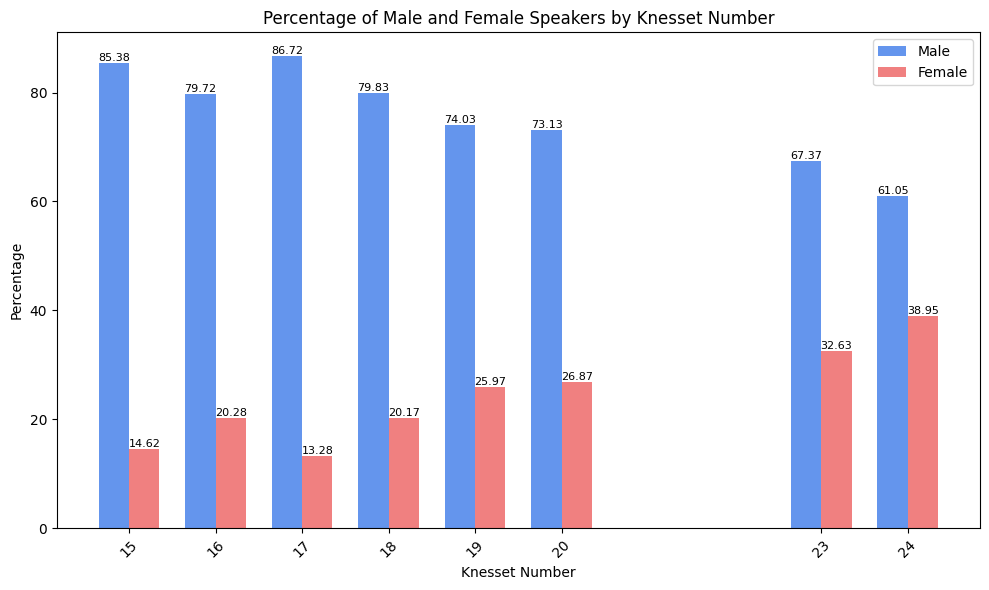

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
bar_positions = gender_percentage.index

bar1 = ax.bar(bar_positions - bar_width/2, gender_percentage['male'], width=bar_width, color='#6495ED', label='Male')
bar2 = ax.bar(bar_positions + bar_width/2, gender_percentage['female'], width=bar_width, color='#F08080', label='Female')
ax.set_xlabel('Knesset Number')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Male and Female Speakers by Knesset Number')
ax.set_xticks(gender_percentage.index)
ax.set_xticklabels(gender_percentage.index)

for bar in bar1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=8)

for bar in bar2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom', fontsize=8)

ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
print(knesset_data_dict.keys())
for knesset_number, factions_dict in knesset_data_dict.items():
    print(knesset_number)
    guest_df = factions_dict.get('אורח')  # Get the "אורח" DataFrame
    if guest_df is not None:
        guest_count = len(guest_df)
    else:
        guest_count = 0  # If no "אורח" faction, set guest_count to 0

    faction_ratios = {}

dict_keys([15, 16, 17, 18, 19, 20, 23, 24])
15
16
17
18
19
20
23
24


guest count  44405
total count  98280
guest count  77701
total count  161338
guest count  77012
total count  163556
guest count  98134
total count  189612
guest count  41164
total count  82627
guest count  135359
total count  293711
guest count  31551
total count  83838
guest count  35103
total count  93113


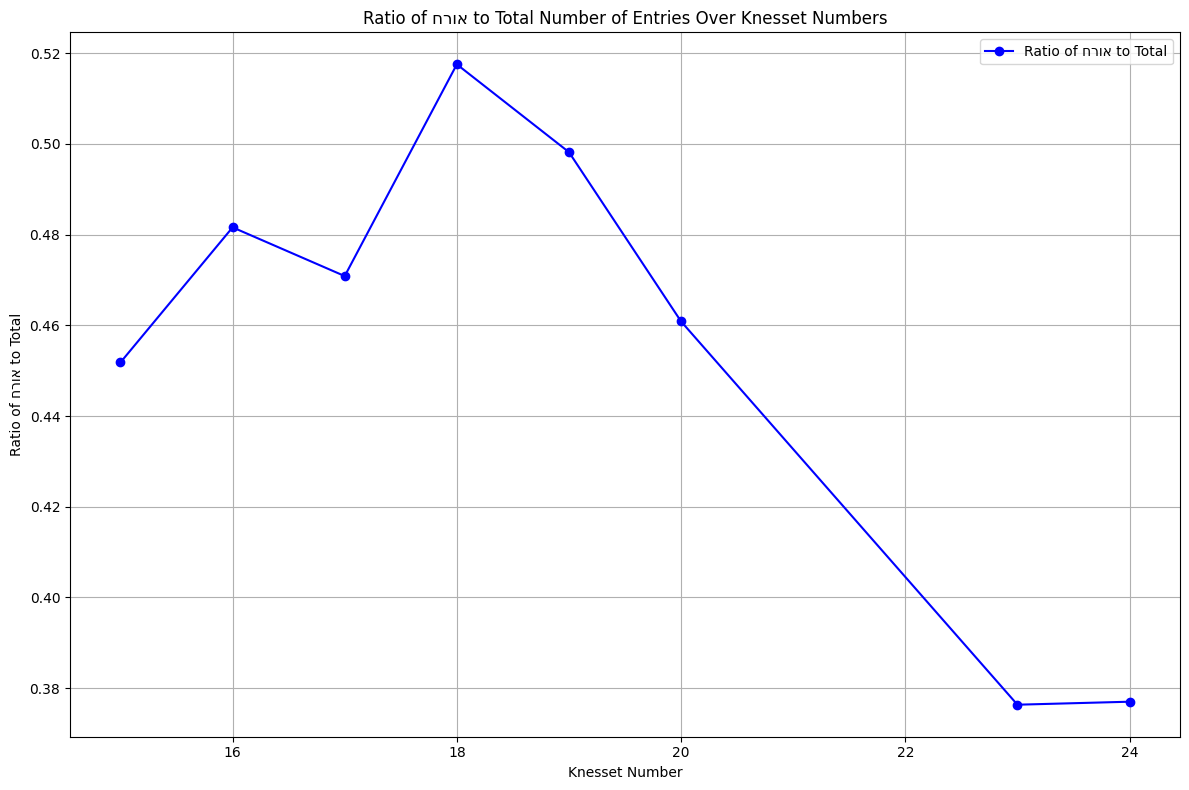

In [23]:
# Plot the ratio of guests per knesset number
ratios_dict = {}
for knesset_number, factions_dict in knesset_data_dict.items():
    guest_df = factions_dict.get('אורח')  # Get the "אורח" DataFrame
    if guest_df is not None:
        guest_count = len(guest_df)
        print("guest count ",guest_count)
    else:
        guest_count = 0  # If no "אורח" faction, set guest_count to 0

    # Calculate the total number of rows across all factions
    total_count = sum(len(faction_df) for faction_df in factions_dict.values())
    print("total count ", total_count)
    # Calculate the ratio of "אורח" to the total number of entries
    if total_count > 0:
        ratio = guest_count / total_count
    else:
        ratio = np.nan  # Handle division by zero if the total count is zero

    # save the ratio
    ratios_dict[knesset_number] = ratio

guest_name = get_display('אורח')

knesset_numbers = sorted(ratios_dict.keys())
ratios = [ratios_dict[knesset_num] for knesset_num in knesset_numbers]
plt.figure(figsize=(12, 8))
plt.plot(knesset_numbers, ratios, marker='o', color='blue', label=f'Ratio of {guest_name} to Total')
plt.xlabel('Knesset Number')
plt.ylabel(f'Ratio of {guest_name} to Total')
plt.title(f'Ratio of {guest_name} to Total Number of Entries Over Knesset Numbers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-24-6dd9d010db8e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=main_df, x=labeled_column_name, palette='Set2')


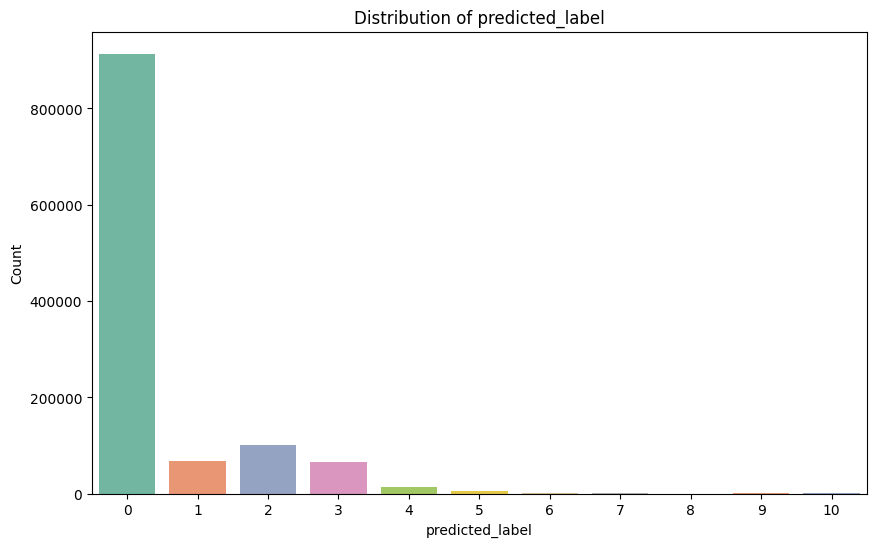

In [24]:
#plot the distribution of the scores
labeled_column_name = 'predicted_label'
plt.figure(figsize=(10, 6))
sns.countplot(data=main_df, x=labeled_column_name, palette='Set2')
plt.title(f'Distribution of {labeled_column_name}')
plt.xlabel(labeled_column_name)
plt.ylabel('Count')
plt.show()


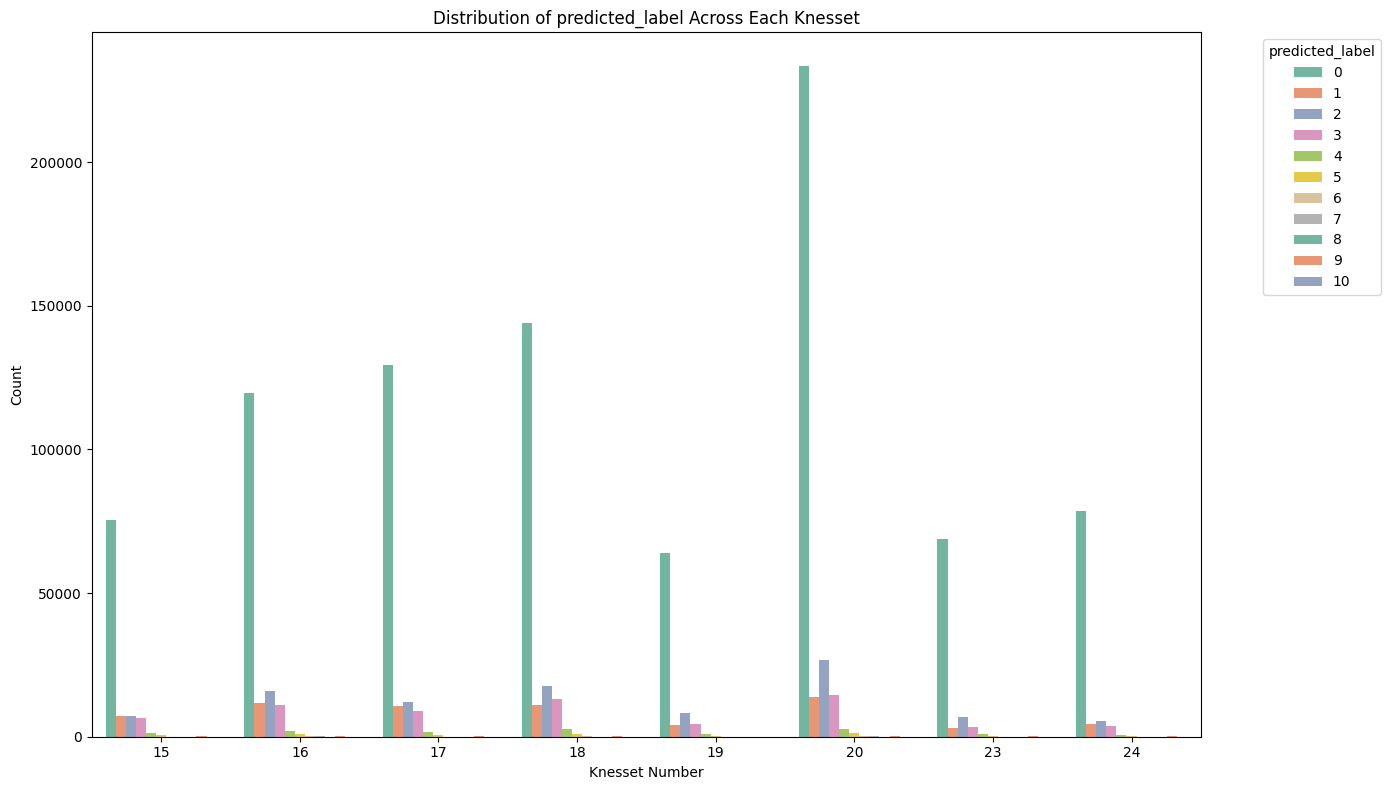

In [25]:
# distribution of predicted labels
knesset_number_column = 'knesset_number'
plt.figure(figsize=(14, 8))
sns.countplot(data=main_df, x=knesset_number_column, hue=labeled_column_name, palette='Set2')
plt.title(f'Distribution of {labeled_column_name} Across Each Knesset')
plt.xlabel('Knesset Number')
plt.ylabel('Count')
plt.legend(title=labeled_column_name, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-26-93d532b89cb2>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportion_9_10.index, y=proportion_9_10.values, palette='Blues_d')


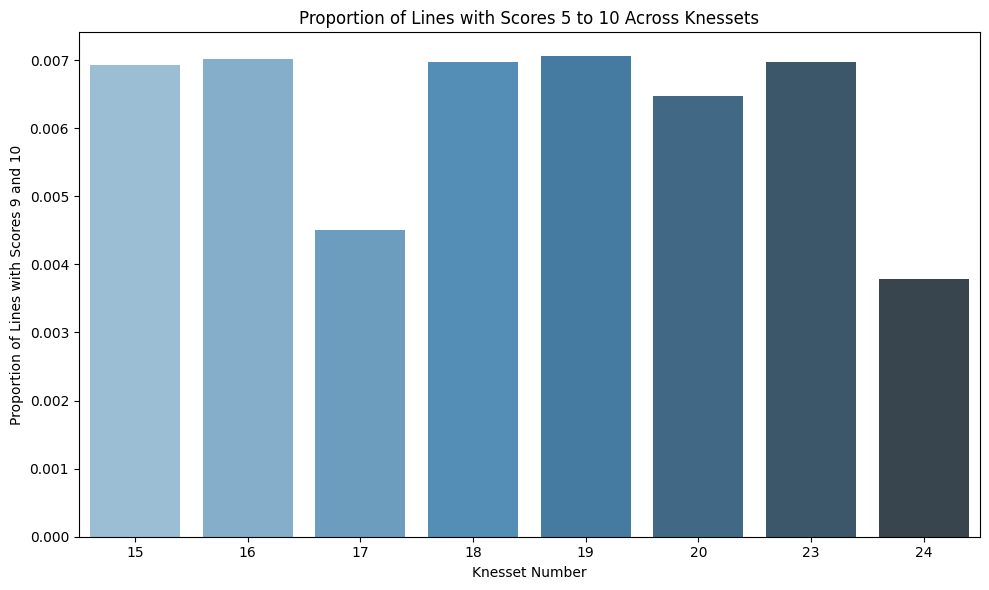

In [26]:
# plot the proportion of labels with score 9 and 10
filtered_df = main_df[main_df[labeled_column_name].isin([5,6,7,8,9,10])]
total_lines_per_knesset = main_df[knesset_number_column].value_counts().sort_index()

# Calculate the number of lines with scores 9 or 10 for each Knesset
lines_with_9_10_per_knesset = filtered_df[knesset_number_column].value_counts().sort_index()

# Calculate the proportion of lines with scores 9 or 10
proportion_9_10 = lines_with_9_10_per_knesset / total_lines_per_knesset

plt.figure(figsize=(10, 6))
sns.barplot(x=proportion_9_10.index, y=proportion_9_10.values, palette='Blues_d')
plt.title('Proportion of Lines with Scores 5 to 10 Across Knessets')
plt.xlabel('Knesset Number')
plt.ylabel('Proportion of Lines with Scores 9 and 10')
plt.tight_layout()
plt.show()

In [27]:
# score of the most popular factions
# filter for only speakers in the party
df_just_knesset_members = main_df[main_df["faction_general_name"] != 'אורח']
df_just_knesset_members

,speaker_name,sentence_text,knesset_number,session_name,protocol_date,morphological_fields,speaker_gender,speaker_religion,speaker_residence,faction_general_name,faction_political_orientation,predicted_label
1,אופיר פינס-פז,"אני מודיע לך, שבבתי המעצר של המשטרה, אני לא מא...",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00:00,"{'id': ['1', '2', '3---4', '3', '4', '5', '6--...",male,יהודי,רעננה,העבודה,שמאל,0
3,אופיר פינס-פז,"תודה רבה.אגף התקציבים, אומרים פה כולם שחסרים א...",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00:00,"{'id': ['1', '2', '3'], 'form': ['תודה', 'רבה'...",male,יהודי,רעננה,העבודה,שמאל,0
6,אופיר פינס-פז,"אתה אומר היום, שיש 10,200 מיטות.",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00:00,"{'id': ['1', '2', '3', '4', '5---6', '5', '6',...",male,יהודי,רעננה,העבודה,שמאל,0
8,אופיר פינס-פז,"יש 10,700 אסירים.",15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00:00,"{'id': ['1', '2', '3', '4'], 'form': ['יש', '1...",male,יהודי,רעננה,העבודה,שמאל,0
10,אופיר פינס-פז,איך זה קורה?,15,"ועדת החוקה, חוק ומשפט",2002-07-01 09:00:00,"{'id': ['1', '2', '3', '4'], 'form': ['איך', '...",male,יהודי,רעננה,העבודה,שמאל,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1166066,אוסאמה סעדי,"שלום, לסיכום אני מבקש ממשרד המשפטים באמת לעשות...",20,"ועדת החוקה, חוק ומשפט",2017-05-16 10:30:00,NaN,male,מוסלמי,NaN,הרשימה המשותפת,ערבים,0
1166068,אוסאמה סעדי,"איך שאמרת, שבאמת נעשית עבודה פנים-ממשלתית גם ע...",20,"ועדת החוקה, חוק ומשפט",2017-05-16 10:30:00,NaN,male,מוסלמי,NaN,הרשימה המשותפת,ערבים,0
1166069,אורי מקלב,"בוקר טוב לכולם, אני מתכבד לפתוח ישיבה של ועדת ...",20,"ועדת החוקה, חוק ומשפט",2017-05-16 09:00:00,NaN,male,יהודי,ירושלים,דגל התורה,חרדים,0
1166071,אלעזר שטרן,"אני רוצה לשאול לגבי התנאי של 2,500 צווי עיקול....",20,"ועדת החוקה, חוק ומשפט",2017-05-16 09:00:00,NaN,male,יהודי,מצפה הושעיה,יש עתיד,מרכז,0


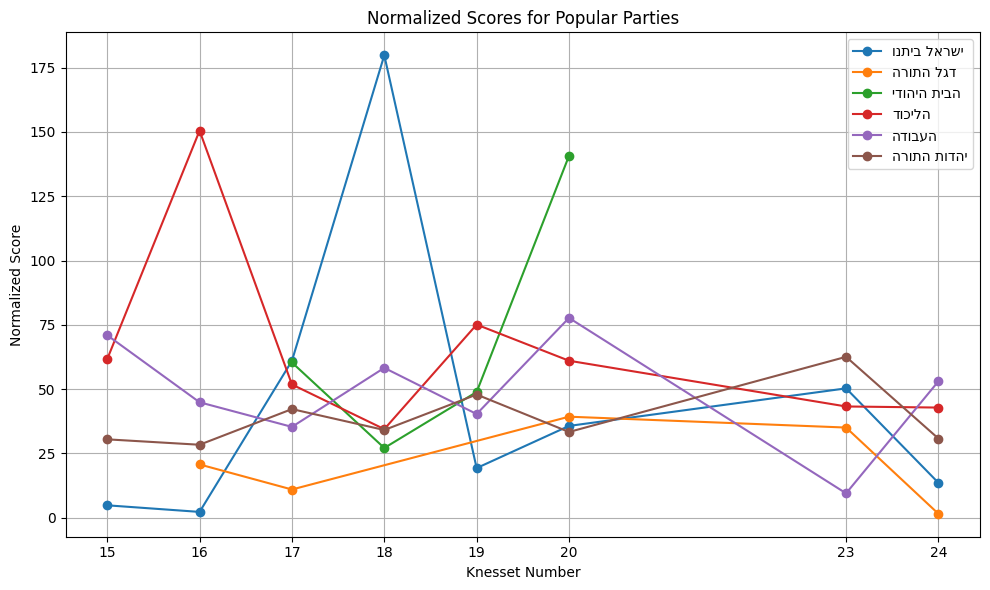

In [28]:
knesset_numbers = np.unique(df_just_knesset_members["knesset_number"])
knesset_numbers.sort()

most_popular_factions = ["ישראל ביתנו", "דגל התורה", "הבית היהודי", "הליכוד", "העבודה", "יהדות התורה"]
total_scores = df_just_knesset_members.groupby(['knesset_number', 'faction_general_name'])['predicted_label'].sum().reset_index()
speech_counts = df_just_knesset_members.groupby(['knesset_number', 'faction_general_name'])['predicted_label'].count().reset_index()

total_scores.columns = ['knesset_number', 'faction_general_name', 'total_score']
speech_counts.columns = ['knesset_number', 'faction_general_name', 'speech_count']
merged_data = pd.merge(total_scores, speech_counts, on=['knesset_number', 'faction_general_name'])
merged_data['normalized_score'] = merged_data['total_score'] / (merged_data['speech_count'] ** 0.5)  # Adjust the exponent as needed

plt.figure(figsize=(10, 6))

for faction in most_popular_factions:
    orientation_data = merged_data[merged_data['faction_general_name'] == faction]
    plt.plot(orientation_data['knesset_number'], orientation_data['normalized_score'], marker='o', label=get_display(faction))

plt.xlabel('Knesset Number')
plt.ylabel('Normalized Score')
plt.title('Normalized Scores for Popular Parties')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.xticks(knesset_numbers)
plt.show()


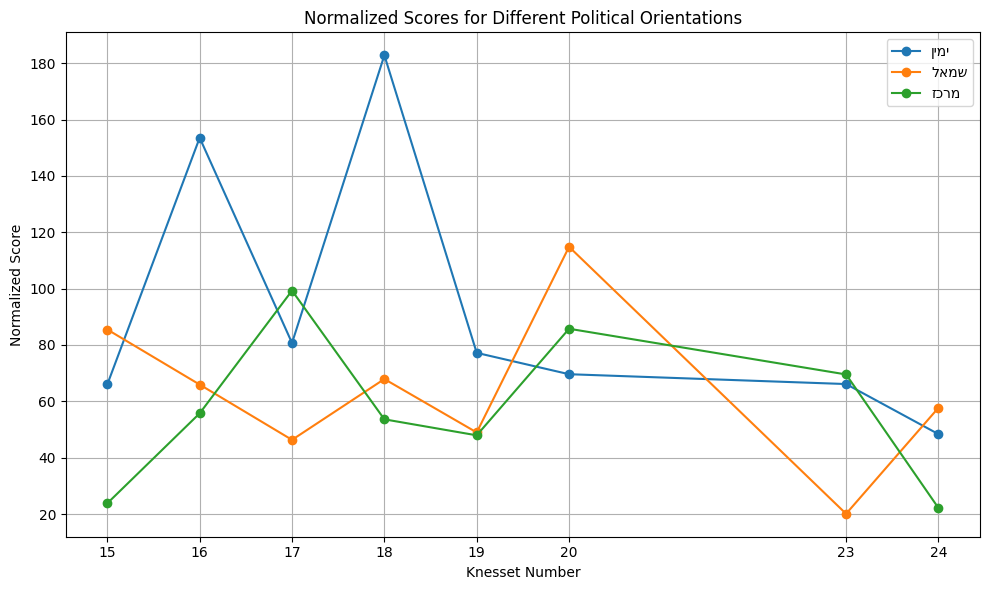

In [29]:
knesset_numbers = np.unique(df_just_knesset_members["knesset_number"])
knesset_numbers.sort()

orientations = ["ימין", "שמאל", "מרכז"]
filtered_df = df_just_knesset_members[df_just_knesset_members['faction_political_orientation'].isin(orientations)]

total_scores = filtered_df.groupby(['knesset_number', 'faction_political_orientation'])['predicted_label'].sum().reset_index()
speech_counts = filtered_df.groupby(['knesset_number', 'faction_political_orientation'])['predicted_label'].count().reset_index()

total_scores.columns = ['knesset_number', 'faction_political_orientation', 'total_score']
speech_counts.columns = ['knesset_number', 'faction_political_orientation', 'speech_count']
merged_data = pd.merge(total_scores, speech_counts, on=['knesset_number', 'faction_political_orientation'])
merged_data['normalized_score'] = merged_data['total_score'] / (merged_data['speech_count'] ** 0.5)  # Adjust the exponent as needed

plt.figure(figsize=(10, 6))

for orientation in orientations:
    orientation_data = merged_data[merged_data['faction_political_orientation'] == orientation]
    plt.plot(orientation_data['knesset_number'], orientation_data['normalized_score'], marker='o', label=get_display(orientation))

plt.xlabel('Knesset Number')
plt.ylabel('Normalized Score')
plt.title('Normalized Scores for Different Political Orientations')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.xticks(knesset_numbers)
plt.show()


In [30]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(main_df['knesset_number'], main_df['predicted_label'])
print(contingency_table)
# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-Square Statistic: {chi2}, p-value: {p}')

from scipy.stats import kruskal

# Group data by Knesset and get scores
grouped_scores = [main_df[main_df['knesset_number'] == knesset]['predicted_label'] for knesset in main_df['knesset_number'].unique()]

# Perform the Kruskal-Wallis test
h_stat, p_value = kruskal(*grouped_scores)

print(f'Kruskal-Wallis H Statistic: {h_stat}, p-value: {p_value}')

predicted_label      0      1      2      3     4     5    6   7   8    9   10
knesset_number                                                                
15                75514   7379   7138   6353  1215   460   54  32   5   97  33
16               119551  11781  15912  10895  2066   781   87  90  10  137  28
17               129452  10778  12008   9073  1509   461   72  44  20  116  23
18               144056  11057  17575  12973  2630   840  111  74  16  237  43
19                64100   4113   8195   4538  1098   416   42  33  11   68  13
20               233561  13976  26875  14576  2820  1339  165  96  31  222  50
23                68693   3194   6985   3463   919   407   29  34   6   80  28
24                78646   4511   5353   3661   590   195   30  29  12   78   8
Chi-Square Statistic: 8846.35834747833, p-value: 0.0
Kruskal-Wallis H Statistic: 5519.733169517619, p-value: 0.0
